In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
opm_ratio = 1.5/10
squid_ratio = 3/10

In [5]:
import numpy as np

def sarvas_formula(r, r0):
    """
    Compute the lead field matrix using Sarvas's formula for MEG forward calculation.
    Source: https://iopscience.iop.org/article/10.1088/0031-9155/32/1/004/pdf
    
    Parameters
    ----------
    r : ndarray, shape (3,)
        Position vector of the measurement point (sensor location)
    r0 : ndarray, shape (3,)
        Position vector of the current dipole
    
    Returns
    -------
    M : ndarray, shape (3, 3)
        Lead field matrix that transforms dipole moment Q into magnetic field B
        such that B = M @ Q
    """
    # Displacement vector from dipole to sensor
    R = r - r0
    R_norm = np.linalg.norm(R)
    
    # Compute F and its gradient
    F = R_norm * (R_norm * R_norm + np.dot(R, r0))
    gradF = (3 * R * np.dot(R, r0) + R_norm * R_norm * R + R_norm * R_norm * r0) / R_norm
    
    # Create the cross product matrix for R
    R_cross = np.array([
        [0, -R[2], R[1]],
        [R[2], 0, -R[0]], 
        [-R[1], R[0], 0]
    ])
    
    # Compute lead field matrix
    M = (10**-7 / F) * (R_norm * R_norm * R_cross - np.outer(gradF, np.cross(r0, R)))
    
    return M



In [6]:
def generate_sphere_grid(n=20, angle_range=50):
    """
    Generate points on a unit sphere surface in an n x n grid pattern.
    The grid spans angle_range degrees in both theta and phi directions.
    
    Parameters
    ----------
    n : int
        Number of points in each dimension of the grid
    angle_range : float
        Angular range in degrees for both dimensions
    
    Returns
    -------
    points : ndarray, shape (n*n, 3)
        Array of 3D coordinates of points on sphere surface
    """
    # Convert angle range to radians
    angle_rad = np.radians(angle_range)
    
    # Center the grid around the north pole (theta=0)
    theta_start = -angle_rad/2
    theta_end = angle_rad/2
    
    # Center phi around 0
    phi_start = -angle_rad/2
    phi_end = angle_rad/2
    
    # Create the grid in spherical coordinates
    theta = np.linspace(theta_start, theta_end, n)
    phi = np.linspace(phi_start, phi_end, n)
    
    # Create meshgrid
    THETA, PHI = np.meshgrid(theta, phi)
    
    # Convert to Cartesian coordinates
    # x = sin(theta)cos(phi)
    # y = sin(theta)sin(phi)
    # z = cos(theta)
    X = np.sin(THETA) * np.cos(PHI)
    Y = np.sin(THETA) * np.sin(PHI)
    Z = np.cos(THETA)
    
    # Stack coordinates into (n*n, 3) array
    points = np.column_stack((X.flatten(), Y.flatten(), Z.flatten()))
    
    return points

# Example usage:
grid_points = generate_sphere_grid(n=20, angle_range=50)
print(f"Generated {len(grid_points)} points on sphere surface")

Generated 400 points on sphere surface


In [7]:
# Generate random points inside a unit sphere
n_points = 4000

# Generate random points in a cube and reject those outside unit sphere
points_1 = []
points_2 = []
while len(points_1) < n_points or len(points_2) < n_points:
    # Generate random coordinates between -1 and 1
    x = np.random.uniform(-1, 1)
    y = np.random.uniform(-1, 1) 
    z = np.random.uniform(-1, 1)
    
    # Check if point is inside unit sphere
    if x*x + y*y + z*z <= 1 - opm_ratio and len(points_1) < n_points:
        points_1.append([x, y, z])
    if x*x + y*y + z*z <= 1 - squid_ratio and len(points_2) < n_points:
        points_2.append([x, y, z])

# Convert to numpy array
points_1 = np.array(points_1)
points_2 = np.array(points_2)

print(f"Generated {len(points_1)} random points inside unit sphere")
print(f"Generated {len(points_2)} random points inside unit sphere")


Generated 4000 random points inside unit sphere
Generated 4000 random points inside unit sphere


In [8]:
import numpy as np

# Convert points_1 and points_2 lists to numpy arrays
points_1 = np.array(points_1)
points_2 = np.array(points_2)

# Assume grid_points (sensor positions, shape: [n_sensors, 3]) and points (dipole positions, shape: [n_dipoles, 3]) are defined.
nsensors = grid_points.shape[0]   # Expected to be 400 sensors
ndipoles_1 = points_1.shape[0]      # Number of dipoles in first sphere
ndipoles_2 = points_2.shape[0]      # Number of dipoles in second sphere

# For each sensor-dipole pair, compute the vector difference (r_vec = sensor_position - dipole_position)
# This will have shape (nsensors, ndipoles, 3)
diff_1 = grid_points[:, None, :] - points_1[None, :, :]
diff_2 = grid_points[:, None, :] - points_2[None, :, :]

# Compute the distances for each sensor-dipole pair
r_1 = np.linalg.norm(diff_1, axis=2)   # Shape: (nsensors, ndipoles) for first sphere
r_safe_1 = np.maximum(r_1, 1e-12)        # Avoid division by zero
r3_1 = r_safe_1 ** 3

r_2 = np.linalg.norm(diff_2, axis=2)   # Shape: (nsensors, ndipoles) for second sphere
r_safe_2 = np.maximum(r_2, 1e-12)
r3_2 = r_safe_2 ** 3

# Compute the unit vector for each sensor-dipole pair
u_1 = diff_1 / r_safe_1[..., None]      # Shape: (nsensors, ndipoles, 3)
u_2 = diff_2 / r_safe_2[..., None]      # Shape: (nsensors, ndipoles, 3)

# For each pair, compute the outer product u * u^T. This yields a 3x3 matrix per pair.
# The resulting array has shape (nsensors, ndipoles, 3, 3)
outer_u_1 = np.einsum('ijk,ijl->ijkl', u_1, u_1)
outer_u_2 = np.einsum('ijk,ijl->ijkl', u_2, u_2)

# Now, for a dipole in free space, the contribution to the magnetic field is given by:
#   (3*(u u^T) - I) / |r|^3 
# where I is the 3x3 identity matrix.
# Compute these 3x3 blocks for all sensor-dipole pairs.
blocks_1 = (3 * outer_u_1 - np.eye(3)[None, None, :, :]) / r3_1[..., None, None]
blocks_2 = (3 * outer_u_2 - np.eye(3)[None, None, :, :]) / r3_2[..., None, None]

# Finally, reshape the blocks into the full forward matrix A, which maps:
#   [dipole moment components (3*ndipoles,)] --> [sensor magnetic field components (3*nsensors,)]
# The desired shape is (3*nsensors, 3*ndipoles)
A_1 = blocks_1.transpose(0, 2, 1, 3).reshape(nsensors * 3, ndipoles_1 * 3)
A_2 = blocks_2.transpose(0, 2, 1, 3).reshape(nsensors * 3, ndipoles_2 * 3)

print("The forward mapping matrices have shapes:", A_1.shape, "and", A_2.shape)


The forward mapping matrices have shapes: (1200, 12000) and (1200, 12000)


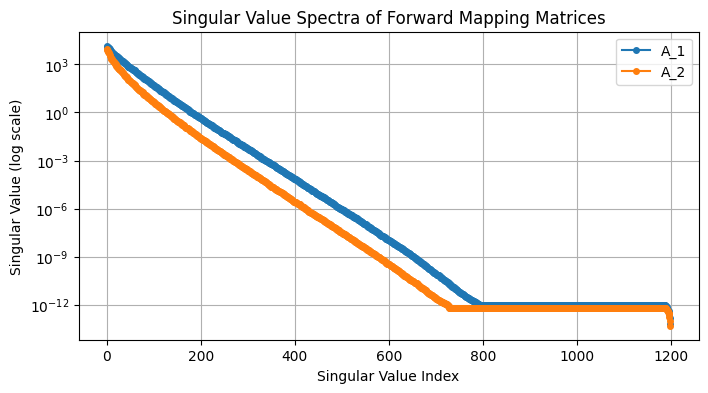

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt

# Compute the singular value decomposition (SVD) of both forward mapping matrices
U1, s1, Vh1 = np.linalg.svd(A_1, full_matrices=False)
U2, s2, Vh2 = np.linalg.svd(A_2, full_matrices=False)

# Plot the singular value spectra on a log scale
plt.figure(figsize=(8, 4))
plt.semilogy(s1, 'o-', markersize=4, label='A_1')
plt.semilogy(s2, 'o-', markersize=4, label='A_2')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value (log scale)')
plt.title('Singular Value Spectra of Forward Mapping Matrices')
plt.grid(True)
plt.legend()
plt.show()


In [10]:
import sys

sys.path.append('../..')
from data_utils import save_svd

save_svd(s1, 'meg_opm')
save_svd(s2, 'meg_squid')


Saved singular value spectrum to /Users/ennucore/dev/gut-of-imaging/results/meg_opm_svd_spectrum.npz
Saved singular value spectrum to /Users/ennucore/dev/gut-of-imaging/results/meg_squid_svd_spectrum.npz
